# **How Does Pre-Training (and Epochs and Batches) Affect the Performance of a Neural Network?**

## **Introduction**

In this section, we will explore how adjusting hyperparameters like **epochs** and **batch sizes** affects the performance of the neural network. Additionally, we will experiment with **pre-trained models** to compare their performance to our simple feedforward network.

To start with, the first few steps of data loading and preparation will be copied from Question 2. If you want to see explanations and reasoning for choices within the code then all the markdown sections are present in questions 1 and 2 for this first part.

One part that's been negatively affecting the models so far is the extreme outliers at the upper end of FRP. Although in the data cleaning stages of Question 1 the FRP was capped at 95%, it still seems like this is what is causing both the Random Forest Regressor and Neural Network to have lower R² scores, so to start with lets try capping the FRP at 80% and see what impact that has.

## **Importing Required Libraries**

The following libraries are used for data processing, neural network training, and visualisation:

- **`os`**: Handles file paths and directories.
- **`torch`**: PyTorch library for building and training neural networks.
- **`torch.nn`**: Contains classes for defining and training neural networks.
- **`torch.optim`**: Provides optimisation algorithms like Adam for training neural networks.
- **`sklearn.model_selection.train_test_split`**: Splits the dataset into training and testing subsets.
- **`sklearn.preprocessing.StandardScaler`**: Standardises features by removing the mean and scaling to unit variance.
- **`sklearn.metrics`**: Provides performance metrics like MSE and R² score.
- **`pandas`**: For data manipulation and analysis.
- **`geopandas`**: Handles geographic data for plotting maps of Australia.
- **`numpy`**: Core library for numerical computing.
- **`matplotlib.pyplot`**: Creates static visualisations like plots and charts.
- **`matplotlib.colors`**: Manages colour normalisation for visualisations.
- **`seaborn`**: Built on `matplotlib`, provides high-level statistical graphics.

In [58]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## **Code Copied from Question 2**

With the inclusion of capping FRP at 80%

In [59]:
# Load the dataset (your own filename or path may be different)
dataset_path = "/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/cleaned_bushfires.csv"
df_cleaned = pd.read_csv(dataset_path)

An additional step here is to cap the FRP even lower than we have been which was 95%. This time we'll try 80%

In [60]:
# Cap the FRP values at the 80th percentile to remove extreme outliers
frp_80th = df_cleaned["frp"].quantile(0.80)
df_cleaned["frp_capped"] = df_cleaned["frp"].clip(upper=frp_80th)

# Remove rows with missing values to ensure a clean dataset for training
df_cleaned = df_cleaned.dropna()

In [61]:
# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv("/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/cleaned_bushfires.csv", index=False)

In [62]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98514 entries, 0 to 98513
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      98514 non-null  float64
 1   longitude     98514 non-null  float64
 2   bright_ti4    98514 non-null  float64
 3   scan          98514 non-null  float64
 4   track         98514 non-null  float64
 5   acq_time      98514 non-null  int64  
 6   bright_ti5    98514 non-null  float64
 7   frp           98514 non-null  float64
 8   type          98514 non-null  int64  
 9   confidence_h  98514 non-null  bool   
 10  confidence_n  98514 non-null  bool   
 11  frp_capped    98514 non-null  float64
dtypes: bool(2), float64(8), int64(2)
memory usage: 7.7 MB


In [63]:
df_cleaned.head()

,latitude,longitude,bright_ti4,scan,track,acq_time,bright_ti5,frp,type,confidence_h,confidence_n,frp_capped
0,-37.48861,149.63156,341.1,0.41,0.60,304,293.7,4.4,0,False,True,4.4
1,-33.94823,151.21292,341.1,0.62,0.54,305,295.3,6.4,0,False,True,6.4
2,-34.45618,150.87723,328.5,0.33,0.55,305,298.1,2.1,2,False,True,2.1
3,-31.60223,150.15147,367.0,0.34,0.56,306,302.4,19.3,0,True,False,11.8
4,-29.26867,149.46602,367.0,0.35,0.57,306,307.0,13.6,0,True,False,11.8


In [64]:
# Define X and y
X = df_cleaned[["bright_ti4", "bright_ti5", "scan", "track", "latitude", "longitude"]]  # Features
y = df_cleaned["frp_capped"]  # Target variable

In [65]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [67]:
# Convert X_train and y_train to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Features
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Target

# Convert X_test and y_test to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Features
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Target

In [68]:
# Convert the training and testing data into PyTorch Tensors and then into TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)  # Create a dataset for training from features and labels
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)     # Create a dataset for testing from features and labels

# Set the batch size for training and testing
batch_size = 64

# Create DataLoader instances to handle batching and shuffling of data for more efficient training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle the training data for each epoch
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle test data (used for evaluation)

In [69]:
# Define a simple feedforward neural network for predicting continuous values (regression)
class FRP_Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FRP_Regressor, self).__init__()
        # Define the layers of the network: input layer, hidden layer, and output layer
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Transform input features to hidden layer
            nn.ReLU(),                         # Apply ReLU activation to the hidden layer
            nn.Dropout(p=0.2),  # Adding dropout with 50% probability
            nn.Linear(hidden_dim, 1)            # Output a single continuous value for regression
        )

    def forward(self, x):
        # Define how data passes through the network during forward propagation
        return self.fc(x)

# Set the input size and hidden layer size
input_dim = X_train.shape[1]  # The number of features in the dataset
hidden_dim = 64               # Number of neurons in the hidden layer

# Initialise the model with the chosen parameters
model = FRP_Regressor(input_dim, hidden_dim)

criterion = nn.MSELoss()  # Using Mean Squared Error for regression
optimiser = optim.Adam(model.parameters(), lr=0.01)

In [70]:
train_losses = []  # Store the training loss at each epoch
test_losses = []   # Store the test (validation) loss at each epoch

# Training the neural network for 50 epochs
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    
    # Forward pass: Pass the training data through the model to get predictions
    predictions = model(X_train_tensor)
    
    # Calculate the loss by comparing the predictions to the true values
    loss = criterion(predictions, y_train_tensor)
    
    # Backward pass: Zero out previous gradients, calculate new gradients, and update the model parameters
    optimiser.zero_grad()  # Zero gradients for the next step
    loss.backward()        # Perform backpropagation to calculate gradients
    optimiser.step()       # Update the model parameters
    
    # Store the loss for this epoch
    train_losses.append(loss.item())

    # Evaluate on test data (validation data)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for evaluation
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
    
    # Store the test loss for this epoch
    test_losses.append(test_loss.item())

    # Print the average loss for every epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 47.3912
Epoch [2/50], Loss: 44.6475
Epoch [3/50], Loss: 41.9360
Epoch [4/50], Loss: 39.3166
Epoch [5/50], Loss: 36.7229
Epoch [6/50], Loss: 34.1700
Epoch [7/50], Loss: 31.6625
Epoch [8/50], Loss: 29.2254
Epoch [9/50], Loss: 26.7978
Epoch [10/50], Loss: 24.4561
Epoch [11/50], Loss: 22.2079
Epoch [12/50], Loss: 20.0836
Epoch [13/50], Loss: 18.0768
Epoch [14/50], Loss: 16.2371
Epoch [15/50], Loss: 14.6053
Epoch [16/50], Loss: 13.1498
Epoch [17/50], Loss: 11.9321
Epoch [18/50], Loss: 10.9473
Epoch [19/50], Loss: 10.2156
Epoch [20/50], Loss: 9.7272
Epoch [21/50], Loss: 9.4142
Epoch [22/50], Loss: 9.2282
Epoch [23/50], Loss: 9.1687
Epoch [24/50], Loss: 9.1011
Epoch [25/50], Loss: 9.0922
Epoch [26/50], Loss: 9.0068
Epoch [27/50], Loss: 8.9379
Epoch [28/50], Loss: 8.7319
Epoch [29/50], Loss: 8.4829
Epoch [30/50], Loss: 8.1558
Epoch [31/50], Loss: 7.8812
Epoch [32/50], Loss: 7.5416
Epoch [33/50], Loss: 7.2503
Epoch [34/50], Loss: 6.9966
Epoch [35/50], Loss: 6.7975
Epoch [36/

In [71]:
torch.save(model.state_dict(), "frp_regressor.pth")
print("frp_regressor.pth saved")

frp_regressor.pth saved


## **Evaluating the Neural Network With FRP Capped Lower**

In [72]:
# Evaluate the model on the training and test data
train_loss = criterion(model(X_train_tensor), y_train_tensor)
test_loss = criterion(model(X_test_tensor), y_test_tensor)

# Print the loss on both the training and test data
print(f"Training Loss (MSE): {train_loss.item():.4f}")
print(f"Test Loss (MSE): {test_loss.item():.4f}")

# Make predictions on the test data
y_pred = model(X_test_tensor).detach().numpy()

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Training Loss (MSE): 5.7979
Test Loss (MSE): 5.6904
RMSE: 2.39
R²: 0.66


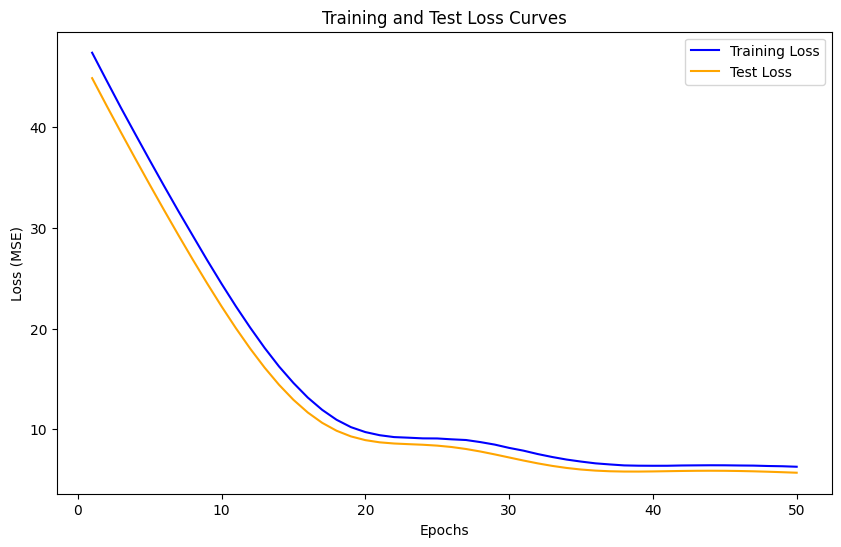

In [73]:
# Plotting the training and test loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()

As we can see that capping of FRP at 80% has greatly improved the model's performance, lowering both **MSE** and **RMSE**, as well as increasing **R²**. From now on we'll continue using this capped FRP.

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]  # Various batch sizes
epochs_values = [10, 20, 50, 100]  # Various numbers of epochs

results = []
train_losses = []
test_losses = []

# Loop through batch sizes and epochs
for batch_size in batch_sizes:
    for epochs in epochs_values:
        # Rebuild the model for each combination of batch size and epochs
        input_dim = X_train.shape[1]  # Number of features in the dataset
        hidden_dim = 64  # Number of neurons in the hidden layer

        # Initialise the model with the chosen parameters
        model = FRP_Regressor(input_dim, hidden_dim)

        criterion = nn.MSELoss()  # Using Mean Squared Error for regression
        optimiser = optim.Adam(model.parameters(), lr=0.01)

        train_losses = []  # Store the training loss at each epoch
        test_losses = []   # Store the test (validation) loss at each epoch

        print(f"Training model with {epochs} epochs and batch size {batch_size}...\n")

        # Train the neural network for the current combination of epochs and batch size
        for epoch in range(epochs):
            model.train()  # Set the model to training mode
            
            # Forward pass: Pass the training data through the model to get predictions
            predictions = model(X_train_tensor)
            
            # Calculate the loss by comparing the predictions to the true values
            loss = criterion(predictions, y_train_tensor)
            
            # Backward pass: Zero out previous gradients, calculate new gradients, and update the model parameters
            optimiser.zero_grad()  # Zero gradients for the next step
            loss.backward()        # Perform backpropagation to calculate gradients
            optimiser.step()       # Update the model parameters
            
            # Store the loss for this epoch
            train_losses.append(loss.item())

            # Evaluate on test data (validation data)
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():  # Disable gradient tracking for evaluation
                test_predictions = model(X_test_tensor)
                test_loss = criterion(test_predictions, y_test_tensor)
            
            # Store the test loss for this epoch
            test_losses.append(test_loss.item())

        # Store the results for this combination
        results.append({
            'batch_size': batch_size,
            'epochs': epochs,
            'final_test_loss': test_losses[-1],
            'train_losses': train_losses,
        })

# Convert results into a DataFrame for better viewing
results_df = pd.DataFrame(results)


Training model with 10 epochs and batch size 16...

Training model with 20 epochs and batch size 16...

Training model with 50 epochs and batch size 16...

Training model with 100 epochs and batch size 16...

Training model with 10 epochs and batch size 32...

Training model with 20 epochs and batch size 32...

Training model with 50 epochs and batch size 32...

Training model with 100 epochs and batch size 32...

Training model with 10 epochs and batch size 64...

Training model with 20 epochs and batch size 64...

Training model with 50 epochs and batch size 64...

Training model with 100 epochs and batch size 64...

Training model with 10 epochs and batch size 128...

Training model with 20 epochs and batch size 128...

Training model with 50 epochs and batch size 128...

Training model with 100 epochs and batch size 128...

Training model with 10 epochs and batch size 256...

Training model with 20 epochs and batch size 256...

Training model with 50 epochs and batch size 256...

T

In [83]:
final_results_df = results_df.drop(columns=['train_losses'])

pd.set_option('display.max_rows', None)
print(final_results_df.to_string(index=False))

 batch_size  epochs  final_test_loss
         16      10        23.792675
         16      20         9.938081
         16      50         5.645374
         16     100         5.081742
         32      10        28.610956
         32      20         8.045686
         32      50         5.697512
         32     100         5.072652
         64      10        26.232801
         64      20         8.305325
         64      50         5.549385
         64     100         5.050362
        128      10        24.729721
        128      20         9.586511
        128      50         5.829494
        128     100         5.114508
        256      10        23.647894
        256      20         9.129277
        256      50         5.895668
        256     100         5.179003


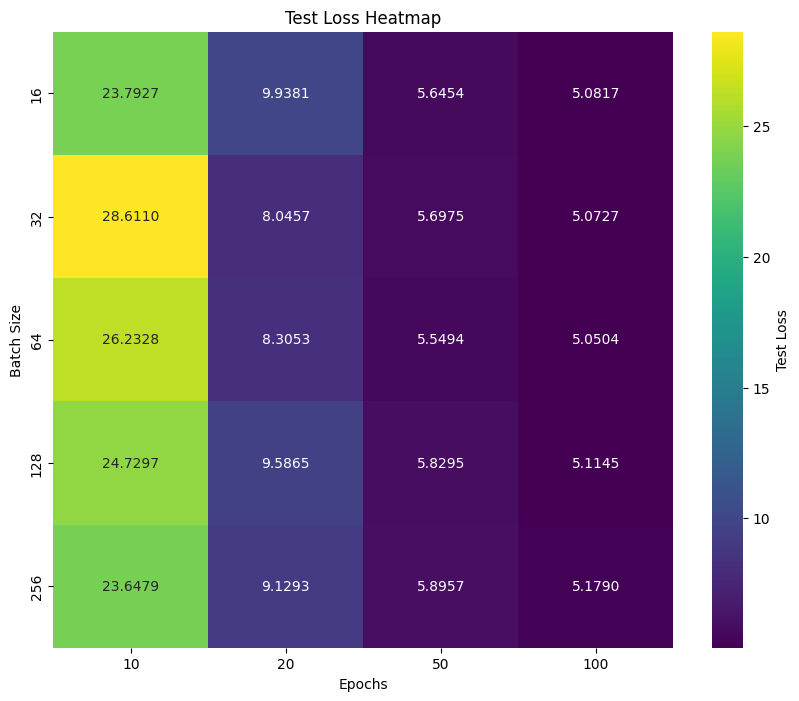

In [ ]:
test_loss_matrix = results_df.pivot(index="batch_size", columns="epochs", values="final_test_loss")

# Create a heatmap for test loss
plt.figure(figsize=(10, 8))
sns.heatmap(test_loss_matrix, annot=True, cmap="viridis", fmt=".4f", cbar_kws={'label': 'Test Loss'})
plt.title("Test Loss Heatmap")
plt.xlabel("Epochs")
plt.ylabel("Batch Size")
plt.show()
